# Code for automated detection of GUVs in a .nd2 file

## About
This code attempts to automatically detect GUVs within a .nd2 file that contains confocal microscopy data of the sample. 

## Use of the code
In the first cell enter the `filename` (.nd2 file), `series_idx` and `channel` that should be used. Then all cell can be executed subsequently

### Pseudocode
The working machanism of the code is illustrated by the pseudocode below
```python
load_file()
preprocess() # select series and convert to correct data type
guess_initial_frame() # attempt to find the frame with most GUVs
GUVs = find_GUV_positions() # obtain xy coordinates of the GUVs
for guv in GUVs:
    properties.append(find_GUV_frames_and_properties(guv)) # obtain the frame in which the GUV intentsity is highest
print(properties) # output the analysis
```

<span style="color:red;font-weight: bold;">NOTE: all indices start at 0, so the first channel is channel <em>0</em></span>

In [219]:
# import necessary packages
import matplotlib as mpl
import matplotlib.pyplot as plt # for plotting
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150
plt.rcParams['image.cmap'] = 'gray'

import numpy as np
from nd2reader import ND2Reader # for handling the nd2 file with PIMS
import pims # for loading files
from PIL import Image # for image processing

from skimage.filters import gaussian
from skimage.measure import label,regionprops
from skimage.feature import canny
from scipy import ndimage as ndi

# Set the variables in the cell below

In [278]:
# setting variables
filename = "../galvano_003_10series.nd2" # path to the nd2 file
channel = 0 # index of the channel to use
series_idx = 2 # integer or None in case of a file with a single series


# =========================================================================
# =========================================================================
# === do not adjust the code below, unless you know what you are doing! ===
# =========================================================================
# =========================================================================

# Running the actual analysis

In [297]:
# definine some helper functions
@pims.pipeline
def as_8bit(frame):
    imin = frame.min()
    imax = frame.max()
    a = (255 - 0) / (imax - imin)
    b = 255 - a * imax
    return (a * frame + b).astype(np.uint8)

@pims.pipeline
def gaussian_5px(frame):
    return gaussian(frame, 5)

def bounded_range(orig_range, min_val, max_val): # remove all items from a range that are outside (min,max)
    l = []
    for i in orig_range:
        if i >= min_val and i <= max_val:
            l.append(i)
    return l
#     return slice(np.min(l),np.max(l)+1)

@pims.pipeline
def process_find_edges(frame):
    return ndi.binary_fill_holes(canny(frame,sigma=5, low_threshold=20, high_threshold=50))

def image_subregion(frame, xlims=[0,100], ylims=[0,100]):
    xmin = xlims[0] if xlims[0] >= 0 else 0
    xmax = xlims[1] if xlims[1] < frame.shape[1] else frame.shape[1]-1
    ymin = ylims[0] if ylims[0] >= 0 else 0
    ymax = ylims[1] if ylims[1] < frame.shape[0] else frame.shape[0]-1
    return frame[slice(ymin,ymax),slice(xmin,xmax)]

def ar(rp):
    if rp['minor_axis_length'] == 0.:
        return rp['major_axis_length']
    else:
        return rp['major_axis_length']/rp['minor_axis_length']

In [280]:
# Loading and processing the file
stack = pims.open(filename)
stack.bundle_axes = 'yx' # have only yx data in one frame
stack.iter_axes = 'z' # iterate over the z axis
stack.default_coords['c'] = channel # select the correct channel
if series_idx:
    stack.default_coords['v'] = series_idx # select the correct channel
stack.default_coords['t'] = 0 # single time
metadata = stack.metadata

frames = as_8bit(stack) # convert to 8-bit image

print("Processing series %d of file '%s' with %d frames by using selected channel '%s' (#%d)" % (series_idx, filename, len(stack), metadata['channels'][channel], channel))

Processing series 2 of file '../galvano_003_10series.nd2' with 31 frames by using selected channel 'Alexa 488 antibody' (#0)


In [281]:
total_intensities = np.zeros((len(frames)))
for i,f in enumerate(frames):
    total_intensities[i] = gaussian_5px(f).sum()
best_frame = np.argmax(total_intensities)

# make mean image
frames_for_mean = bounded_range(range(best_frame-3, best_frame+4), 0, len(frames)) # make a sublist of 3 frames below and above best_frame (if possible)
mean_image = as_8bit(np.array(gaussian_5px(frames[frames_for_mean])).mean(axis=0)) # take the mean image of that substack
filled = ndi.binary_fill_holes(canny(mean_image)) # do an edge detection and fill the holes 
regions = regionprops(label(filled)) # get information about the different regions in the image

centroids = np.ceil(np.array(list(map(lambda x: (x.centroid[1], x.centroid[0]), regions)))).astype(np.uint) # get the centres of each of the GUVs
radii = np.ceil(0.5 * np.array(list(map(lambda x: x.major_axis_length, regions)))).astype(np.uint) # and their respective radii

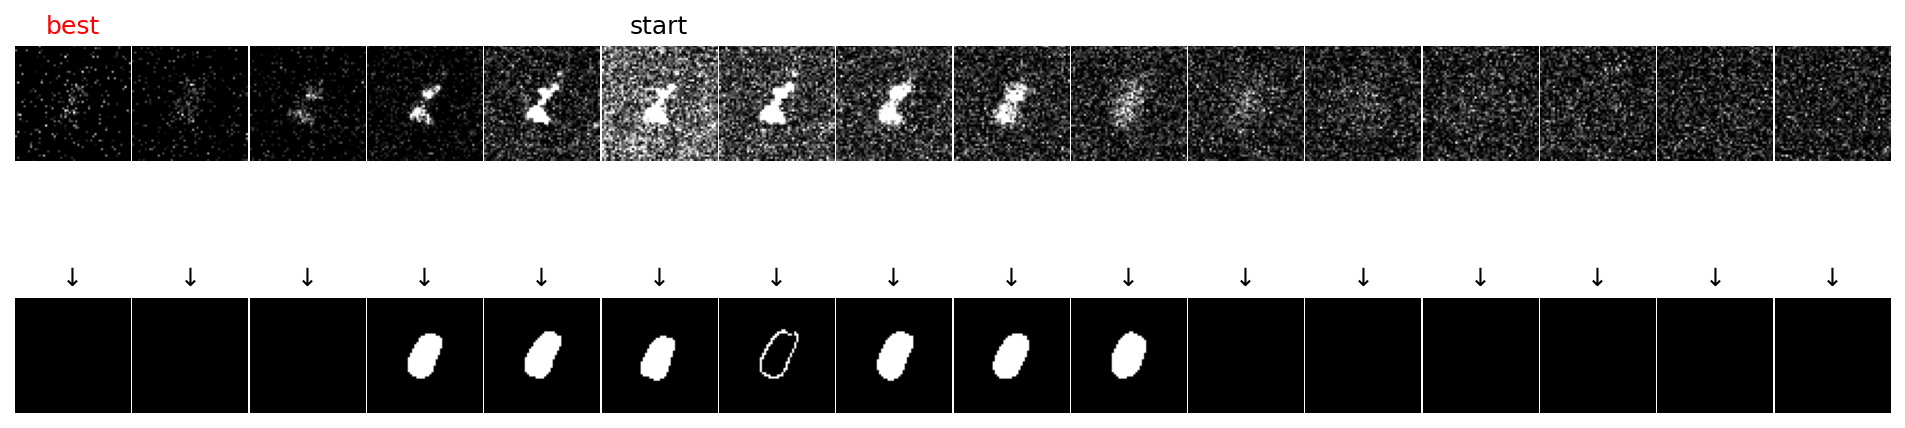

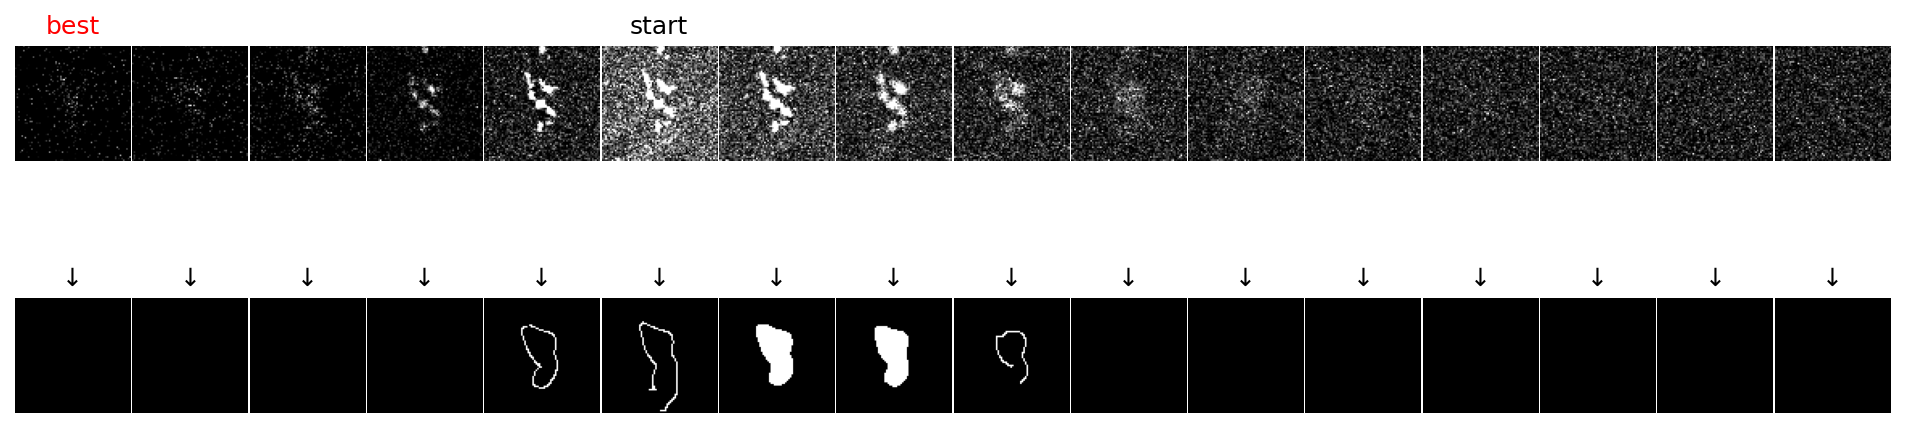

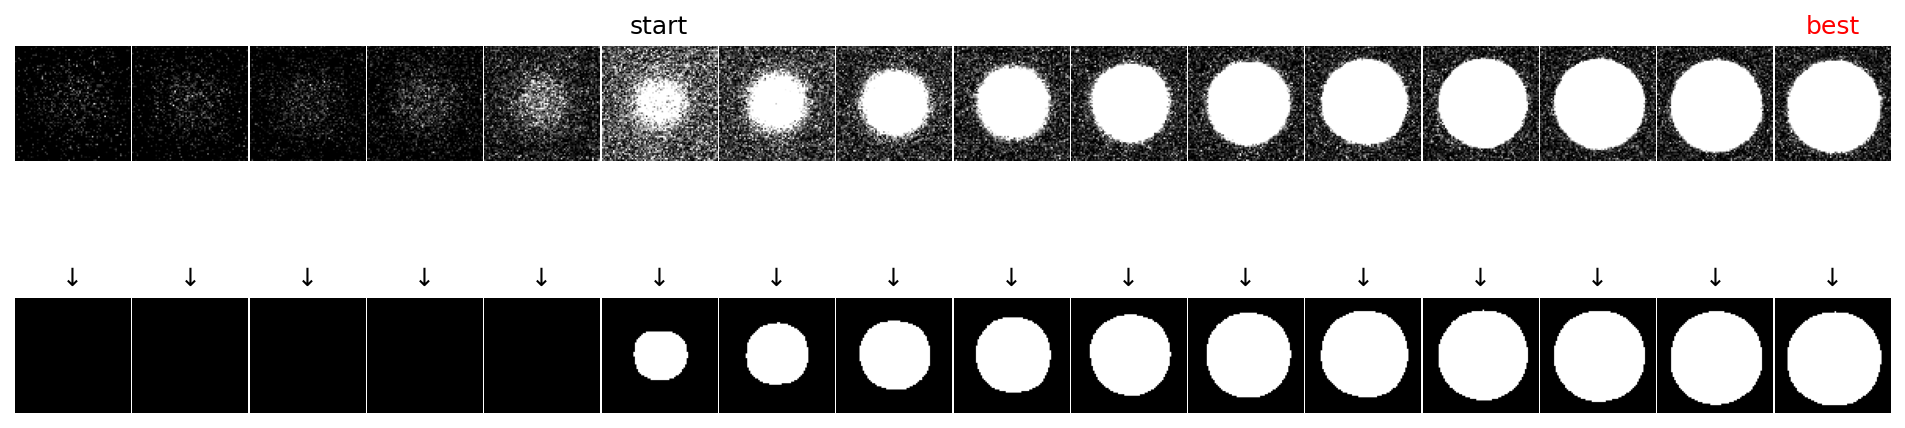

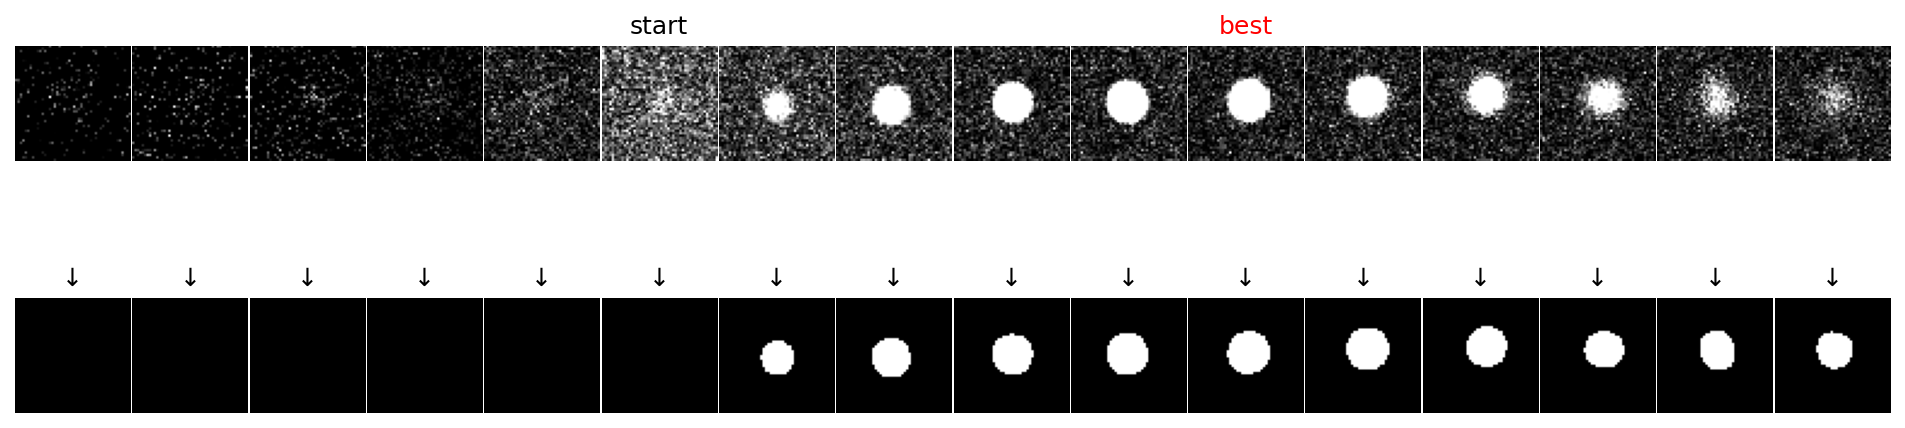

In [304]:
# process the GUVs one by one to find the frame with highest area
for i in range(len(centroids)-2):
    c = centroids[i]
    x,y = c[0],c[1]
    margin = 15
    r = radii[i]+margin
    frames_for_finding_maxInt = bounded_range(range(best_frame-10, best_frame+11), 0, len(frames))
    figw, figh = mpl.figure.figaspect(.02*len(frames_for_finding_maxInt))
    fig,ax = plt.subplots(2,len(frames_for_finding_maxInt),figsize=(figw, figh))
    local_regions = []
    for i,f in enumerate(frames_for_finding_maxInt):
        img_raw = image_subregion(frames[f], [x-r,x+r], [y-r,y+r])
        ax[0,i].imshow(img_raw)
        ax[0,i].axis('off')
        img = process_find_edges(img_raw)
        regs = regionprops(label(img))
        filtered_regs = filter(lambda x: ar(x) < 1.3, regs) # filter regions with an aspect ratio lower than 1.3
        sorted_local_regions = sorted(filtered_regs, key = lambda i: i['area']) # sort filtered regions by decreasing area
        if sorted_local_regions: 
            local_regions.append(sorted_local_regions[0])
        else:
            local_regions.append({'area': 0, 'centroid': (0,0)}) # no regions found, so add empty one
        ax[1,i].imshow(img)
        if f == best_frame:
            ax[0,i].set_title('start')
        ax[1,i].axis('off')
        ax[1,i].set_title(r"↓")
    areas = list(map(lambda x: x['area'], local_regions))
    areas = list(map(lambda x: x['area'], local_regions))
    max_area_idx = np.argmax(areas)
    ax[0,max_area_idx].set_title('best', c='r')
    plt.tight_layout(pad=0.0, w_pad=0.1, h_pad=0.1)